In [18]:
from pynq import Overlay
overlay = Overlay('/home/xilinx/pi-radio-overlays/cfo_correction/cfo_correction.bit')
overlay?

In [5]:
from pynq.lib import AxiGPIO
from pynq import allocate

# Data DMA
data_dma = overlay.axi_dma_0
data_dma_out = overlay.axi_dma_1
# AXI GPIO
gpio_regs = overlay.axi_gpio_0

In [6]:
# Ensure waveform playback is inactive
gpio_regs.write(0x8,0x0)

In [7]:
# Disable cfo
gpio_regs.write(0x0,0x1)

In [8]:

import numpy as np
from numpy import loadtxt

nfft = 1024
cp_len = 256
ofdm_symbols = 10
symbol_length = nfft + cp_len;
#pre_cfo_data = loadtxt('/home/xilinx/pi-radio-overlays/cfo_correction/pre_cfo_data.txt')
pre_cfo_data = loadtxt('/home/xilinx/pi-radio-overlays/cfo_correction/cw_samples.txt')

# Re-format into 16-bit integers:
#pre_cfo_data = np.int16(pre_cfo_data/np.max(abs(pre_cfo_data)) * 2**15 - 1)
#pre_cfo_data = np.int16(pre_cfo_data)
pre_cfo_data = pre_cfo_data.astype(np.int16)

# Allocate pysically contiguous buffer for DMA
in_data_buffer = allocate(shape=(symbol_length*ofdm_symbols*2,),dtype=np.int16)
out_data_buffer = allocate(shape=((symbol_length-cp_len)*ofdm_symbols,),dtype=np.int16)

# Copy OFDM waveform to buffer
np.copyto(in_data_buffer,pre_cfo_data)

data_dma.sendchannel.transfer(in_data_buffer)
data_dma.sendchannel.wait()

# Clear buffer
in_data_buffer.close()

In [9]:
# Playback waveform
# Ensure waveform playback is inactive
gpio_regs.write(0x8,0x1)

data_dma_out.recvchannel.transfer(out_data_buffer)
data_dma_out.recvchannel.wait()

out_samples = np.empty(shape=((symbol_length-cp_len)*ofdm_symbols,),dtype=np.int16)
np.copyto(out_samples,out_data_buffer)

out_data_buffer.close()

In [10]:
# Write to text file
np.savetxt('/home/xilinx/pi-radio-overlays/cfo_correction/cfo_output_samples.txt',out_samples,fmt='%i')

In [11]:
# Bypass CFO
gpio_regs.write(0x0,0x1)

In [12]:
# Enable CFO
gpio_regs.write(0x0,0x0)

In [13]:
#len(pre_cfo_data)
len(out_samples)
print(ofdm_symbols)

10


In [14]:
%matplotlib notebook
import matplotlib.pyplot as plt

def plot_to_notebook(time_sec,in_signal,n_samples,out_signal=None,out_signal2=None):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-',label='Input signal')
    if out_signal is not None:
        plt.plot(time_sec[:n_samples]*1e6,out_signal[:n_samples],'g-',linewidth=1,label='FIR1 output')
    if out_signal2 is not None:
        plt.plot(time_sec[:n_samples]*1e6,out_signal2[:n_samples],'b-',linewidth=1,label='FIR2 output')
    plt.legend()

<IPython.core.display.Javascript object>


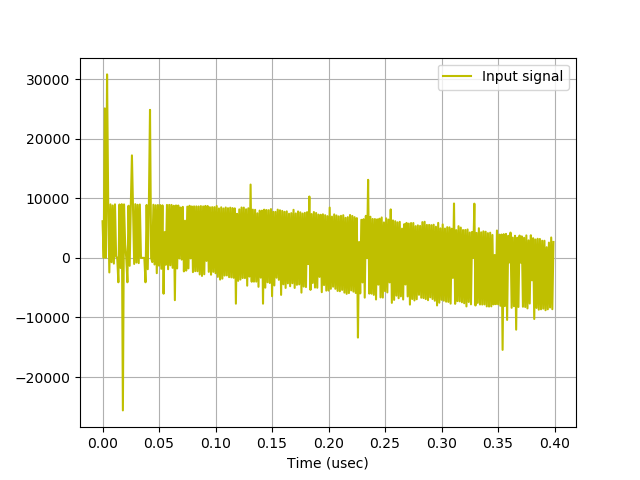

In [16]:
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
# print(pre_cfo_data)
# Number of samples in symbol
n = nfft*ofdm_symbols
# Number of samples to plot
n_plot = 400
Fs = 1000000000
T = n/Fs
# Time Vector
t = np.linspace(0,T,n,endpoint=False)
plot_to_notebook(t,out_samples,n_plot)

In [12]:
out_samples

array([21256, -3584,    14, ...,     0,     0,     0], dtype=int16)